In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import pandas as pd
import sklearn
import sklearn.svm
import sklearn.metrics
from sklearn.cross_validation import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcess

##Download the data

In [3]:
star_file = np.load("data/RR_Lyrae_data.npz")
star_colors, star_class = star_file['arr_0'], star_file['arr_1']

##Stack the data and store it in a pandas dataframe

In [4]:
stacked = np.hstack((star_colors, star_class.reshape(star_class.shape[0], 1)))
col_names = ['u-g', 'g-r', 'r-i', 'i-z', 'class']
star_df = pd.DataFrame(stacked, columns=col_names)

##Plot the enitre dataset with a pairplot from seaborn

/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


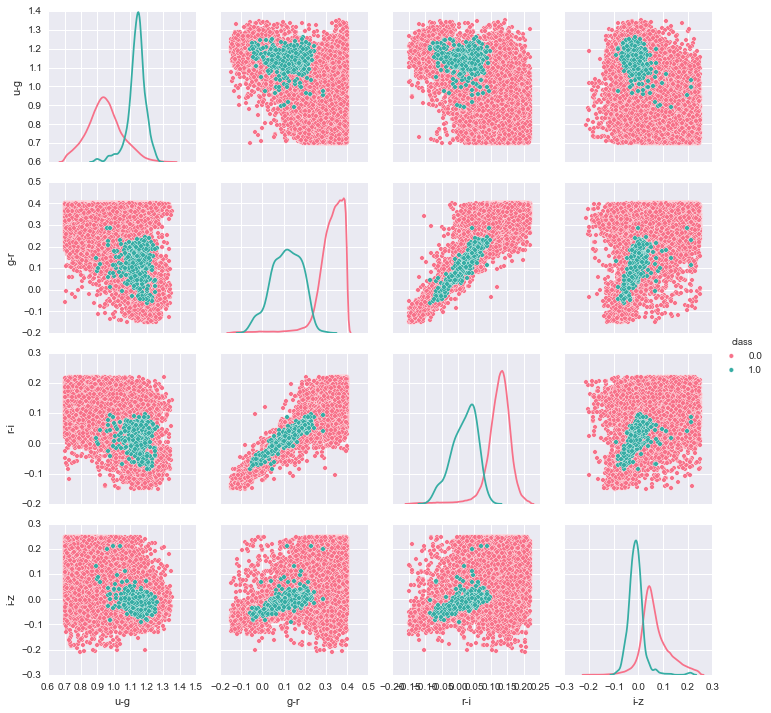

In [5]:
sns.pairplot(star_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

##Divide the data into train and test sets

In [6]:
colors_train, colors_test, labels_train, labels_test = train_test_split(star_colors, star_class, 
                                                                        test_size=0.25, random_state=13)

##Function to compute results

In [7]:
def compute_results(y_true, y_pred):
    fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(y_true, y_pred, pos_label=1)
    precision_p, recall_p, thresholds_pr = sklearn.metrics.precision_recall_curve(y_true, y_pred, pos_label=1)
    
    y_hard_decisions = np.round(y_pred)
    
    precision = sklearn.metrics.precision_score(y_true, y_hard_decisions)
    recall = sklearn.metrics.recall_score(y_true, y_hard_decisions)
    
    f1 = sklearn.metrics.f1_score(y_true, y_hard_decisions)
    roc_score = sklearn.metrics.roc_auc_score(y_true, y_hard_decisions)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_hard_decisions)
    
    results = {'roc': [fpr, tpr, thresholds_roc],
               'pr': [precision_p, recall_p, thresholds_pr],
               'scores': [precision, recall, f1, roc_score, accuracy]}
    return results

##Functions to train models

In [8]:
def logistic_regression_classification(x_train, y_train, x_test, y_test):
    log_regr = LogisticRegression(class_weight='auto')
    log_regr.fit(x_train, y_train)
    predicted_proba = log_regr.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [9]:
def svm_classification(x_train, y_train, x_test, y_test):
    svm = SVC(kernel='linear', class_weight='auto', probability=True)
    svm.fit(x_train, y_train)
    predicted_proba = svm.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [10]:
def decision_Tree_classification(x_train, y_train, x_test, y_test):
    d_tree = DecisionTreeClassifier(max_depth=12, criterion='entropy')
    d_tree.fit(x_train, y_train)
    predicted_proba = d_tree.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [11]:
def knn_classification(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    predicted_proba = knn.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [12]:
def random_forest_classification(x_train, y_train, x_test, y_test):
    rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
    rf.fit(x_train, y_train)
    predicted_proba = rf.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [13]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def gaussian_process_classification(x_train, y_train, x_test, y_test):
    gp = GaussianProcess(theta0=20.)
    gp.fit(x_train[::20], y_train[::20])
    pred = gp.predict(x_test)
    probs = sigmoid(pred)
    return compute_results(labels_test, probs)

##Function to run the models and plot the results

In [ ]:
def run_models(x_train, y_train, x_test, y_test):
    results = dict()
    
    #RUN Models
    
    #Logistic Regression
    logistic_results = logistic_regression_classification(x_train, y_train, x_test, y_test)
    results['Log Reg'] = logistic_results
    
    # SVM Basically the same as Logistic Regression and takes a while to train
    svm_results = svm_classification(x_train, y_train, x_test, y_test)
    results['SVM'] = svm_results
    
    #Decision Tree
    d_tree_resuts = decision_Tree_classification(x_train, y_train, x_test, y_test)
    results['D Tree'] = d_tree_resuts
    
    #KNN
    knn_resuts = knn_classification(x_train, y_train, x_test, y_test)
    results['KNN'] = knn_resuts
    
    #Random Forest
    rf_resuts = random_forest_classification(x_train, y_train, x_test, y_test)
    results['Random Forest'] = rf_resuts
    
    #Gaussian Process
    gp_resuts = gaussian_process_classification(x_train, y_train, x_test, y_test)
    results['GP'] = gp_resuts
    
    # Print reports
    scores = []
    models = []
    for model, results_dict in results.items():
        models.append(model)
        scores.append(results_dict['scores'])
    
    column_names = ['precision', 'recall', 'F1', 'ROC_AUC', 'Accuracy']
    score_df = pd.DataFrame(scores, columns=column_names, index=models)
    print score_df
    
    #PLOT ROC
    for model, result_dict in results.items():
        plt.plot(result_dict['roc'][0], result_dict['roc'][1], label=model)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    plt.figure()
    
    #PLOT Precision Recall
    for model, result_dict in results.items():
        plt.plot(result_dict['pr'][0], result_dict['pr'][1], label=model)
               
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()
    

In [ ]:
run_models(colors_train, labels_train, colors_test, labels_test)